<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision Exercises

In [1]:
import requests
import torch
import torchvision
import matplotlib.pyplot as plt

from pathlib import Path 
from torch.utils.data import DataLoader
from torch import nn

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

## Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.15MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.46MB/s]


In [3]:
class_names = train_dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Visualize at least 5 different samples of the MNIST training dataset.

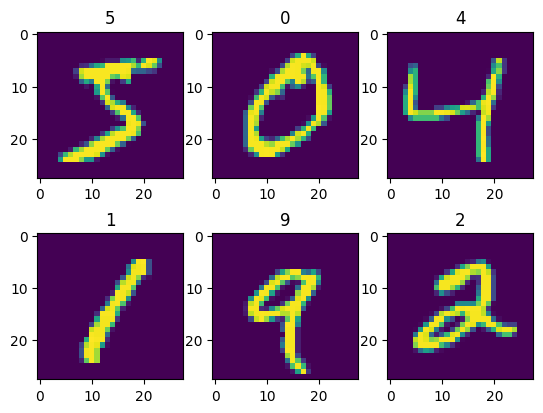

In [4]:
plt.figure()

for i in range(6):
    image, label = train_dataset[i]
    plt.subplot(2, 3, i + 1)
    plt.imshow(image.squeeze())
    plt.title(label)

plt.show()

## Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

## Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [6]:
class CNNModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1
            ),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

## Train the model  for 5 epochs on CPU and GPU and see how long it takes on each.

In [7]:
model = CNNModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
epochs = 5

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0

    model.train()
    
    for X_train, y_train in train_dataloader:
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y_train, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    model.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_y_pred = model(X_test)
            loss = criterion(test_y_pred, y_test)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_y_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Epoch: 0
Train loss: 0.20552 | Train accuracy: 93.32%
Test loss: 0.10218 | Test accuracy: 96.46%

Epoch: 1
Train loss: 0.06932 | Train accuracy: 97.90%
Test loss: 0.09856 | Test accuracy: 96.86%

Epoch: 2
Train loss: 0.05589 | Train accuracy: 98.33%
Test loss: 0.08118 | Test accuracy: 97.36%

Epoch: 3
Train loss: 0.04838 | Train accuracy: 98.53%
Test loss: 0.06917 | Test accuracy: 97.90%

Epoch: 4
Train loss: 0.04348 | Train accuracy: 98.67%
Test loss: 0.08660 | Test accuracy: 97.27%



## Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [27]:
import random

test_samples = []
test_labels = []

for X_test, y_test in random.sample(list(test_dataset), k=6):
    test_samples.append(X_test)
    test_labels.append(y_test)

In [28]:
pred_probs = []

model.eval()

with torch.inference_mode():
    for sample in test_samples:
        pred_logit = model(torch.unsqueeze(sample, dim=1))
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        pred_probs.append(pred_prob)

In [31]:
pred_classes = torch.stack(pred_probs).argmax(dim=1)
pred_classes, test_labels

(tensor([6, 8, 4, 4, 7, 8]), [6, 8, 4, 4, 7, 8])

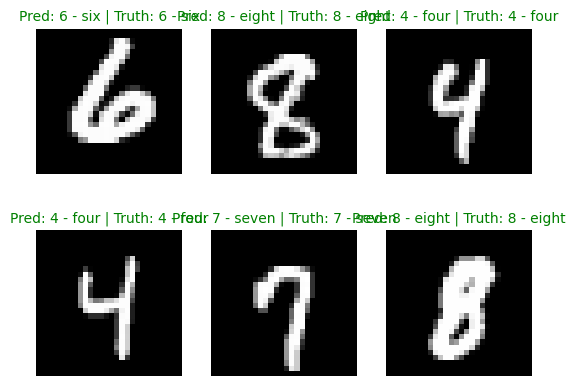

In [32]:
plt.figure()
nrows = 2
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
  
    plt.axis(False);